# NASA TurboFan dataset analysis

The NASA TurboFan dataset analysis is to predict the Remaining Useful Life (RUL) for an engine based on sensor data. The analysis uses Long Short Term Memory implementation to predict the RUL.

# Import Libraries

In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

Using TensorFlow backend.


# Data Ingestion

Import the FD001 dataset for test, train and RUL_test values and adding columns. The dataset has information regarding 21 sensors for 100 different unit numbers.

In [2]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# read training data
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - without failure events recorded.
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# Data Preprocessing

Creating a new variable called Remaining Useful Life (RUL) which is the difference of the maximum cycles by each cycle for every unit number.

In [3]:
# Train data
# Data Labeling - generate column RUL(Remaining Usefull Life)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

Normalize the sensor data using MinMaxScaler functions for test and train data

In [4]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Test Data
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5   s6        s7        s8        s9  s10       s11       s12       s13  \
0  0.0  1.0  0.652174  0.212121  0.127614  0.0  0.208333  0.646055  0.220588   
1  0.0  1.0  0.805153  0.166667  0.146684  0.0  0.386905  0.739872  0.264706   
2  0.0  1.0  0.685990  0.227273  0.158081  0.0  0.386905  0.699360  0.220588   
3  0.0  1.0  0.679549  0.196970  0.105717  0.0  0.255952  0.573561  0.250000   
4  0.0  1.0  0.694042  0.166667  0.102396  0.0  0.273810  0.737740  0.220588   

        s14       s15  s16      

Combine the true RUL values with test data

In [5]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [6]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [7]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


# Reshaping data for LSTM (Long Short-Term Memory) implementation

Pick a window size of 50 cycles which is the look back window for each input sequence going in the model.

In [8]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [9]:
# generator for the sequences by calling the function
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [10]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

In [11]:
label_array = np.concatenate(label_gen).astype(np.float32)

# Modeling

Next, we build a deep network. The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. Dropout is also applied after each LSTM layer to control overfitting. Final layer is a Dense output layer and linear activation since this is a regression problem.

In [12]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
                   )


Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 28s - loss: 8710.3030 - mean_absolute_error: 74.5772 - val_loss: 8122.0660 - val_mean_absolute_error: 71.6629
Epoch 2/100
 - 26s - loss: 8034.5133 - mean_absolute_error: 70.6551 - val_loss: 7603.1378 - val_mean_absolute_error: 68.6511
Epoch 3/100
 - 24s - loss: 7524.9604 - mean_absolute_error: 67.7193 - val_loss: 7112.2845 - val_mean_absolute_error: 65.8186
Epoch 4/100
 - 23s - loss: 7048.8563 - mean_absolute_error: 64.9864 - val_loss: 6652.9623 - val_mean_absolute_error: 63.1854
Epoch 5/100
 - 26s - loss: 6601.9862 - mean_absolute_error: 62.4949 - val_loss: 6219.3952 - val_mean_absolute_error: 60.7207
Epoch 6/100
 - 27s - loss: 6178.0143 - mean_absolute_error: 60.0813 - val_loss: 5816.2370 - val_mean_absolute_error: 58.4487
Epoch 7/100
 - 24s - loss: 5789.7657 - mean_absolute_error: 57.9417 - val_loss: 5445.8657 - val_mean_absolute_error: 56.3820
Epoch 8/100
 - 24s - loss: 5433.5244 - mean_absolute_error: 55.9662 - val_los

In [14]:
# list all data in history
print(history.history.keys())


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


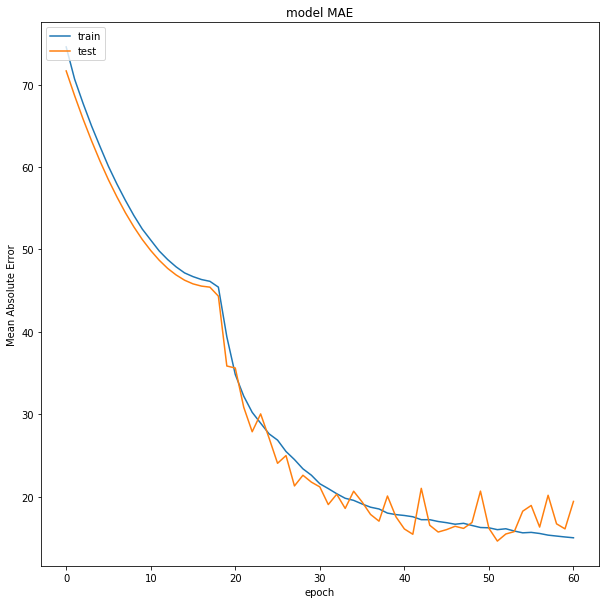

In [15]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

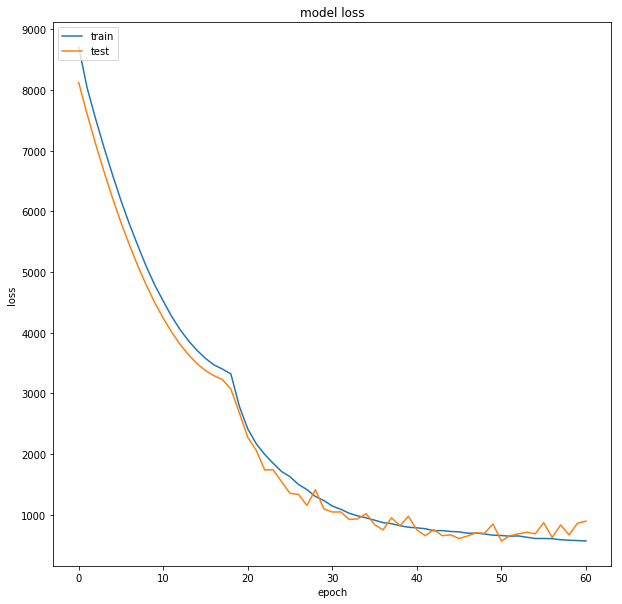

In [16]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)

15631/15631 [==============================] - 8s 520us/step


In [18]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

15631/15631 [==============================] - 9s 568us/step


In [19]:
test_set = pd.DataFrame(y_pred)

# Evaluate on test data

In [20]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

seq_array_test_last
(93, 50, 25)


In [21]:
# Similarly, we pick the labels
# print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
# print("label_array_test_last")
# print(label_array_test_last)

(93, 1)


In [22]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[0]))
print('\nR^2: {}'.format(scores_test[1]))

y_pred_test = model.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)


MAE: 400.95694330687166

R^2: 13.859568360031291


In [23]:
np.concatenate((y_pred_test,y_true_test), axis = 1)
print("Mean squared error :")
mean_squared_error(y_true_test, y_pred_test)

Mean squared error :


400.95694

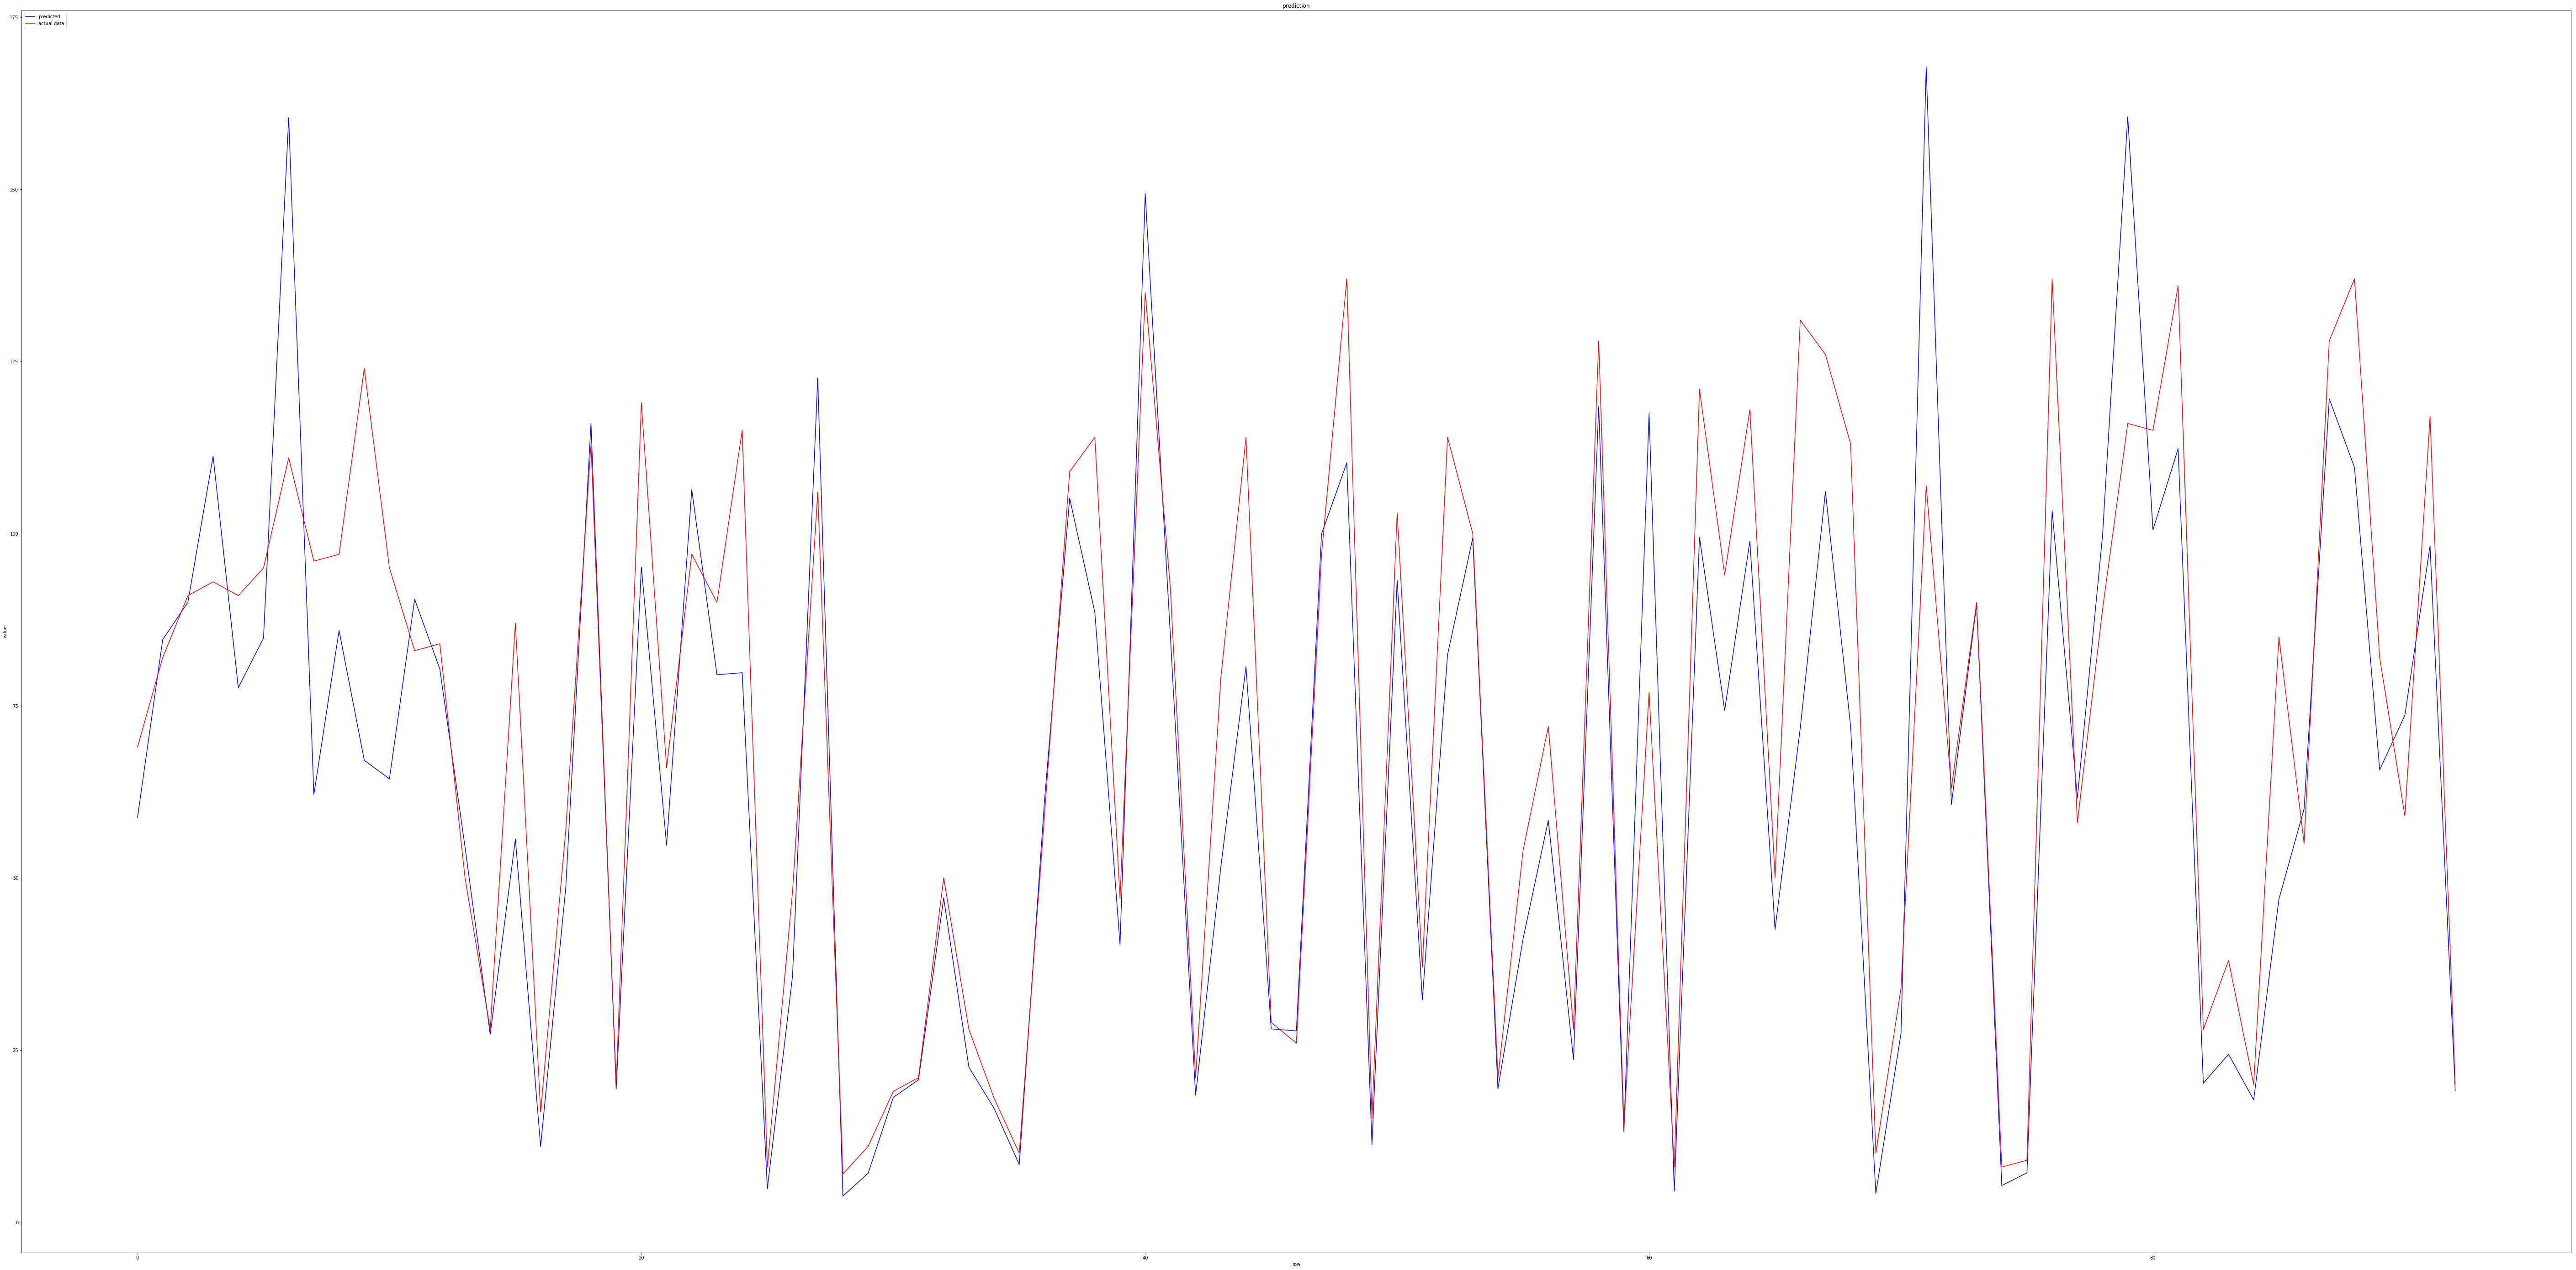

In [24]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="red")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
